In [395]:
import pandas as pd
import numpy as np
import altair as alt
from datetime import datetime
import warnings
import os

# Suppress harmless warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Directory for cleaned data
CLEANED_DATA_DIR = "data_cleaned"

# File paths
TYPHOON_FILE = os.path.join(CLEANED_DATA_DIR, "Typhoon_Dataset - Sheet8.csv")

# Visualization settings
CHART_WIDTH = 1000
CHART_HEIGHT = 400
X_DOMAIN_START = '2021-01-01'
X_DOMAIN_END = '2025-09-01'

# Price file list
PRICE_FILES = [
    "Rootcrops-Food-Prices_Clean_Tidy_Province_Only.csv",
    "Leafy-Vegetables-Food-Prices_Clean_Tidy_Province_Only.csv",
    "Fruits-Food-Prices_Clean_Tidy_Province_Only.csv",
    "Fruit-Vegetables-Food-Prices_Clean_Tidy_Province_Only.csv",
    "Condiments-Food-Prices_Clean_Tidy_Province_Only.csv"
]

In [397]:
# --- 2. Load and Process Typhoon Data ---
try:
    df_typhoons_raw = pd.read_csv(TYPHOON_FILE)
    df_typhoons_raw['Date_Entered_PAR'] = pd.to_datetime(
        df_typhoons_raw['Date Entered PAR'], errors='coerce'
    )
    df_typhoons = df_typhoons_raw.dropna(subset=['Date_Entered_PAR'])
    df_typhoons = df_typhoons[['Typhoon Name', 'Date_Entered_PAR', 'Classification', 'Peak Intensity']]
    print("✅ Typhoon data loaded and processed.")
except FileNotFoundError:
    print(f"❌ Typhoon data not found at {TYPHOON_FILE}.")
    df_typhoons = pd.DataFrame()


✅ Typhoon data loaded and processed.


In [417]:
def create_typhoon_chart(price_file_name, crop_type_name, top_n=5):
    if df_typhoons.empty:
        print("⚠️ No typhoon data available.")
        return None

    # Load price data
    file_path = os.path.join(CLEANED_DATA_DIR, price_file_name)
    try:
        df_prices = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"❌ Missing file: {file_path}")
        return None

    # Prepare date column
    df_prices['Date'] = pd.to_datetime(
        df_prices['Year'].astype(str) + ' ' + df_prices['Month'], 
        format='%Y %B'
    )

    # Filter typhoon events within price data range
    min_date, max_date = df_prices['Date'].min(), df_prices['Date'].max()
    df_typhoons_filtered = df_typhoons[
        (df_typhoons['Date_Entered_PAR'] >= min_date) & 
        (df_typhoons['Date_Entered_PAR'] <= max_date)
    ]

    # --- Compute volatility and select top N commodities ---
    commodity_volatility = df_prices.groupby('Commodity_Name')['Retail_Price'].std().reset_index()
    top_commodities = commodity_volatility.sort_values('Retail_Price', ascending=False).head(top_n)['Commodity_Name'].tolist()

    # Compute national average for only the top volatile commodities
    df_national_avg = df_prices[df_prices['Commodity_Name'].isin(top_commodities)].groupby(
        ['Date', 'Commodity_Name']
    ).agg(Retail_Price=('Retail_Price', 'mean')).reset_index()

    # --- Base chart ---
    base = alt.Chart(df_national_avg).encode(
        x=alt.X('Date:T', title='Date'),
        y=alt.Y('Retail_Price:Q', title='National Avg Price (PHP/KG)'),
        color=alt.Color('Commodity_Name:N', title=f'{crop_type_name} Commodity')
    )

    # Price line with points
    lines = base.mark_line(point=True).encode(
        tooltip=[
            alt.Tooltip('Date:T', title='Month', format="%Y %B"),
            alt.Tooltip('Commodity_Name:N', title='Commodity'),
            alt.Tooltip('Retail_Price:Q', title='Avg Price (PHP)', format=',.2f')
        ]
    )

    # Typhoon vertical lines
    typhoon_rules = alt.Chart(df_typhoons_filtered).mark_rule(
        color='red', strokeDash=[5, 3]
    ).encode(
        x='Date_Entered_PAR:T',
        tooltip=[
            alt.Tooltip('Date_Entered_PAR:T', title='Typhoon Entered PAR', format="%Y-%m-%d"),
            'Typhoon Name:N',
            'Classification:N',
            'Peak Intensity:N'
        ]
    )

    # Combine and display
    chart = (lines + typhoon_rules).properties(
        width=800,
        height=400,
        title=f'National Average {crop_type_name} Prices vs Typhoon Events (Top {top_n} Volatile Commodities)'
    ).interactive(bind_y=False)

    return chart


In [401]:
# --- 4. Generate Charts for All Price Files ---
print("--- Generating and displaying all 5 Typhoon Timeline Charts ---")

for file_name in PRICE_FILES:
    crop_type_key = file_name.split('_Food_Prices')[0]
    crop_type_name = crop_type_key.replace('_', ' ').title().replace('Fruit Vegetables', 'Fruit and Vegetables')
    
    chart = create_typhoon_chart(file_name, crop_type_name)
    if chart:
        print(f"✅ Chart ready for: {crop_type_name}")
        chart.display()


--- Generating and displaying all 5 Typhoon Timeline Charts ---
✅ Chart ready for: Rootcrops-Food-Prices Clean Tidy Province Only.Csv


alt.LayerChart(...)

✅ Chart ready for: Leafy-Vegetables-Food-Prices Clean Tidy Province Only.Csv


alt.LayerChart(...)

✅ Chart ready for: Fruits-Food-Prices Clean Tidy Province Only.Csv


alt.LayerChart(...)

✅ Chart ready for: Fruit-Vegetables-Food-Prices Clean Tidy Province Only.Csv


alt.LayerChart(...)

✅ Chart ready for: Condiments-Food-Prices Clean Tidy Province Only.Csv


alt.LayerChart(...)

In [403]:
# --- 1️⃣ Calculate mean and standard deviation per commodity ---
stats = all_prices.groupby('Commodity_Name')['Retail_Price'].agg(['mean', 'std']).reset_index()

# --- 2️⃣ Merge stats back to the main DataFrame ---
df_featured = all_prices.merge(stats, on='Commodity_Name', how='left')

# --- 3️⃣ Create the Price_Spike feature ---
df_featured['Price_Spike'] = df_featured['Retail_Price'] > (df_featured['mean'] + 1.5 * df_featured['std'])

# --- 4️⃣ Price Spike Summary per Commodity ---
spike_summary = (
    df_featured.groupby('Commodity_Name')['Price_Spike']
    .sum()  # count True values
    .reset_index(name='Spike_Count')
    .sort_values('Spike_Count', ascending=False)
)

# Display top 10 commodities with most spikes
print(spike_summary.head(10))

                          Commodity_Name  Spike_Count
3                                 CARROT          475
24                         GINGER, LOOSE          473
7                 EGGPLANT, LONG, PURPLE          455
36                                TOMATO          451
1         BITTER GOURD (AMPALAYA), FRUIT          435
32                                POTATO          428
2                                CABBAGE          402
6                      CUCUMBER (PIPINO)          401
34                                SQUASH          357
9   FRESH FRUIT, BANANA, LAKATAN, MEDIUM          357


In [405]:
volatility = (
    all_prices.groupby('Commodity_Name')['Retail_Price']
    .std()
    .reset_index()
    .rename(columns={'Retail_Price': 'Price_Std'})
)

# --- 2. Sort and get top 10 ---
top_10_volatility = volatility.sort_values(by='Price_Std', ascending=False).head(10)
top_10_volatility

,Commodity_Name,Price_Std
28,ONION RED CREOLE (BERMUDA RED),70.524611
29,ONION WHITE (YELLOW GRANEX),69.147625
16,"FRESH FRUIT, LANZONES",59.108714
24,"GINGER, LOOSE",43.626907
19,"FRESH FRUIT, MANGO, PIKO, RIPE, MEDIUM",42.869705
8,"FRESH FRUIT, AVOCADO",40.397671
12,"FRESH FRUIT, GRAPES",39.457042
18,"FRESH FRUIT, MANGO, KALABAW, RIPE, MEDIUM",38.237211
3,CARROT,36.233504
32,POTATO,35.512329


🌱 Top 10 Commodities with Lowest Average Lag (Months):
                           Commodity_Name      mean  median  count
34                                 SQUASH  0.968254     1.0     63
1          BITTER GOURD (AMPALAYA), FRUIT  0.969697     1.0     66
4                                 CHAYOTE  0.969697     1.0     66
21  FRESH FRUIT, PINEAPPLE, PINYA, MEDIUM  0.969697     1.0     66
10  FRESH FRUIT, BANANA, LATUNDAN, MEDIUM  0.969697     1.0     66
11      FRESH FRUIT, BANANA, SABA, MEDIUM  0.969697     1.0     66
24                          GINGER, LOOSE  0.969697     1.0     66
37                     TURNIP (SINGKAMAS)  1.000000     1.0     22
22                            GABI TUBERS  1.000000     1.0     31
23                          GARLIC, LOCAL  1.000000     1.0     24

🔥 Bottom 5 Commodities with Highest Average Lag (Months):
                            Commodity_Name      mean  median  count
17      FRESH FRUIT, MANGO, INDIAN, MEDIUM  1.184211     1.0     38
19  FRESH FRU

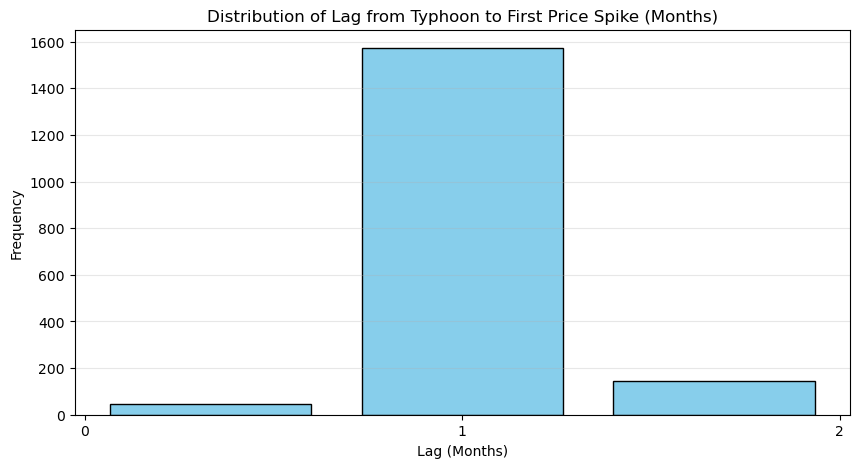

In [407]:

# Ensure dates are in datetime format

# Create 'Date' column in df_featured from Year and Month
if 'Date' not in df_featured.columns and 'Year' in df_featured.columns and 'Month' in df_featured.columns:
    df_featured['Date'] = pd.to_datetime(
        df_featured['Year'].astype(str) + ' ' + df_featured['Month'], 
        format='%Y %B',
        errors='coerce'
    )

# Standardize typhoon dataframe columns
df_typhoons.columns = df_typhoons.columns.str.strip()
df_typhoons['Typhoon_Date'] = pd.to_datetime(df_typhoons['Date_Entered_PAR'], errors='coerce')
df_typhoons['Typhoon_Name'] = df_typhoons['Typhoon Name']

# 2️⃣ Sort for consistency
df_featured = df_featured.sort_values(['Commodity_Name', 'Date'])
df_typhoons = df_typhoons.sort_values('Typhoon_Date')

# 3️⃣ Loop through typhoons and compute lag
lags = []

for _, typhoon in df_typhoons.iterrows():
    typhoon_date = typhoon['Typhoon_Date']
    typhoon_name = typhoon['Typhoon_Name']

    if pd.isna(typhoon_date):
        continue  # skip typhoons with missing date

    # Consider spikes within 2 months after typhoon
    window_end = typhoon_date + pd.DateOffset(months=2)
    spikes_after = df_featured[
        (df_featured['Price_Spike'] == True) &
        (df_featured['Date'] >= typhoon_date) &
        (df_featured['Date'] <= window_end)
    ]

    if not spikes_after.empty:
        # Find first spike per commodity
        first_spikes = spikes_after.groupby('Commodity_Name')['Date'].min().reset_index()

        # Calculate lag in months
        first_spikes['Lag_Months'] = (
            (first_spikes['Date'].dt.year - typhoon_date.year) * 12 +
            (first_spikes['Date'].dt.month - typhoon_date.month)
        )

        first_spikes['Typhoon_Name'] = typhoon_name
        lags.append(first_spikes)

# 4️⃣ Combine all lag records
if lags:
    df_lag = pd.concat(lags, ignore_index=True)

    # 5️⃣ Summary Statistics
    lag_summary = df_lag.groupby('Commodity_Name')['Lag_Months'].agg(['mean', 'median', 'count']).reset_index()
    lag_summary = lag_summary.sort_values('mean')

    print("🌱 Top 10 Commodities with Lowest Average Lag (Months):")
    print(lag_summary.head(10))

    print("\n🔥 Bottom 5 Commodities with Highest Average Lag (Months):")
    print(lag_summary.tail(5))

    # 6️⃣ Optional: visualize lag distribution
    plt.figure(figsize=(10,5))
    plt.hist(df_lag['Lag_Months'], bins=3, color='skyblue', edgecolor='black', rwidth=0.8)
    plt.title("Distribution of Lag from Typhoon to First Price Spike (Months)")
    plt.xlabel("Lag (Months)")
    plt.ylabel("Frequency")
    plt.xticks([0,1,2])
    plt.grid(axis='y', alpha=0.3)
    plt.show()
else:
    print("⚠️ No spikes found in the given window.")


In [450]:
# --- Step 1: Compute top regions by total spikes ---
region_total_spikes = (
    df_featured[df_featured['Price_Spike'] == True]
    .groupby('Region')
    .size()
    .reset_index(name='Total_Spikes')
    .sort_values('Total_Spikes', ascending=False)
)

# Select top N regions, e.g., top 5
top_region_names = region_total_spikes['Region'].head(5)
top_region_names

2             I - Ilocos Region
6    Negros Island Region (NIR)
7              V - Bicol Region
4               MIMAROPA Region
3             IV-A - CALABARZON
Name: Region, dtype: object

In [446]:
# Filter spikes for top regions
top_region_spikes = df_featured[
    (df_featured['Region'].isin(top_region_names)) & 
    (df_featured['Price_Spike'] == True)
]

# Count spikes per commodity per region
top_commodities = (
    top_region_spikes
    .groupby(['Region', 'Commodity_Name'])
    .size()
    .reset_index(name='Spike_Count')
    .sort_values(['Region', 'Spike_Count'], ascending=[True, False])
)

# Keep only top 3 commodities per region
top_commodities_per_region = top_commodities.groupby('Region').head(5).reset_index(drop=True)

top_commodities_per_region


,Region,Commodity_Name,Spike_Count
0,I - Ilocos Region,"GINGER, LOOSE",167
1,I - Ilocos Region,"BITTER GOURD (AMPALAYA), FRUIT",149
2,I - Ilocos Region,"EGGPLANT, LONG, PURPLE",143
3,I - Ilocos Region,"FRESH FRUIT, BANANA, LATUNDAN, MEDIUM",122
4,I - Ilocos Region,"FRESH FRUIT, PINEAPPLE, PINYA, MEDIUM",118
5,IV-A - CALABARZON,SQUASH,89
6,IV-A - CALABARZON,CUCUMBER (PIPINO),58
7,IV-A - CALABARZON,"EGGPLANT, LONG, PURPLE",55
8,IV-A - CALABARZON,"FRESH FRUIT, BANANA, LATUNDAN, MEDIUM",49
9,IV-A - CALABARZON,"BITTER GOURD (AMPALAYA), FRUIT",48
